In [5]:
pip install xlsxwriter


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 7.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# ============================================================
# ONE-FILE KAGGLE SCRIPT:
# Training + Policy Enforcement + Effectiveness + Excel Export
# ============================================================

Loading data from: /kaggle/input/communication-devstack-dataset/keystone_features_parsed_struct.csv
Raw shape: (222308, 17)
Columns: ['process_id', 'application_number', 'request_sequence', 'src_ip', 'num_vars', 'vars_size_bytes', 'timestamp', 'method', 'path', 'response_size_bytes', 'processing_time_ms', 'http_version', 'status', 'num_headers', 'headers_size_bytes', 'core_switches', 'core_number']
After cleaning: (222308, 17)
Numeric columns: ['process_id', 'application_number', 'num_vars', 'vars_size_bytes', 'response_size_bytes', 'processing_time_ms', 'http_version', 'status', 'num_headers', 'headers_size_bytes', 'core_switches', 'core_number']
Numeric shape: (222308, 12)

Training IsolationForest (unsupervised)...
Training time: 9134.57 ms

Policy action distribution (unsupervised, by risk thresholds):
action
allow    219012
mfa        3054
deny        242
Name: count, dtype: int64

Proxy policy effectiveness (using HTTP status & method heuristic):
                                 

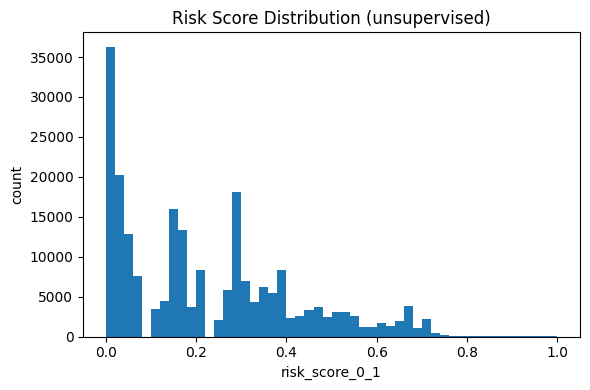


DONE.
You now have an unsupervised Keystone enforcement pipeline:
- IsolationForest anomalies → risk scores
- risk → allow/deny/MFA actions
- proxy effectiveness metrics & latency overhead in Excel.


In [6]:
# ============================================================
# UNSUPERVISED KEYSTONE PIPELINE (ONE FILE)
# - IsolationForest anomaly detection
# - Keystone-style policy middleware (allow/deny/MFA)
# - Proxy policy effectiveness metrics
# - Latency / overhead experiment
# - All tables → keystone_unsupervised_results.xlsx
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest

# ------------------------------------------------------------
# 1. CONFIG
# ------------------------------------------------------------
# Adjust this path if needed in Kaggle
DATA_PATH = "/kaggle/input/communication-devstack-dataset/keystone_features_parsed_struct.csv"

EXCEL_OUT = "keystone_unsupervised_results.xlsx"

# Thresholds for policy actions based on risk score in [0, 1]
RISK_DENY_THRESHOLD = 0.90   # risk >= 0.90 → deny
RISK_MFA_THRESHOLD  = 0.70   # 0.70 ≤ risk < 0.90 → MFA
# risk < 0.70 → allow

# Proxy “malicious” rules (for effectiveness *only*, not for training)
STATUS_ERROR_THRESHOLD = 400  # HTTP status >= 400 → error
SUSPICIOUS_METHODS = {"POST", "DELETE", "PUT", "PATCH"}

# ------------------------------------------------------------
# 2. LOAD DATA
# ------------------------------------------------------------
print("Loading data from:", DATA_PATH)
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Raw shape:", df.shape)
print("Columns:", df.columns.tolist())

# Simple cleaning (no label column needed)
df = df.dropna(axis=0, how="any")
df = df.loc[:, ~df.columns.str.contains('unnamed', case=False)]
print("After cleaning:", df.shape)

# Basic dataset info
dataset_info = pd.DataFrame(
    {
        "n_rows": [df.shape[0]],
        "n_cols": [df.shape[1]],
        "columns": [df.columns.tolist()]
    }
)

# ------------------------------------------------------------
# 3. FEATURE MATRIX FOR UNSUPERVISED LEARNING
# ------------------------------------------------------------
# Use numeric features only (IsolationForest)
numeric_df = df.select_dtypes(include=[np.number]).copy()
print("Numeric columns:", numeric_df.columns.tolist())
print("Numeric shape:", numeric_df.shape)

X = numeric_df.values  # (n_samples, n_features)

model_info = pd.DataFrame(
    {
        "model": ["IsolationForest"],
        "n_features": [numeric_df.shape[1]],
        "n_samples": [numeric_df.shape[0]]
    }
)

# ------------------------------------------------------------
# 4. UNSUPERVISED MODEL: ISOLATION FOREST
# ------------------------------------------------------------
iso = IsolationForest(
    n_estimators=200,
    contamination=0.05,   # expected fraction of anomalies (tune if needed)
    random_state=42,
    n_jobs=-1
)

print("\nTraining IsolationForest (unsupervised)...")
start_train = time.perf_counter()
iso.fit(X)
end_train = time.perf_counter()
train_time_ms = (end_train - start_train) * 1000.0
print(f"Training time: {train_time_ms:.2f} ms")

# decision_function: higher → more normal, lower → more anomalous
decision_scores = iso.decision_function(X)  # shape (n_samples,)
# Convert to risk: higher risk for more anomalous
risk_raw = -decision_scores
risk_min, risk_max = risk_raw.min(), risk_raw.max()
risk_score = (risk_raw - risk_min) / (risk_max - risk_min + 1e-9)  # normalize to [0,1]

# Add scores to a dataframe tied back to original data
scores_df = pd.DataFrame(
    {
        "risk_score_0_1": risk_score,
        "decision_score_raw": decision_scores
    }
)

# ------------------------------------------------------------
# 5. KEYSTONE-STYLE POLICY MIDDLEWARE
# ------------------------------------------------------------
def keystone_policy_action(risk: float) -> str:
    """
    Map risk score in [0,1] to Keystone-style enforcement action.
    """
    if risk >= RISK_DENY_THRESHOLD:
        return "deny"
    elif risk >= RISK_MFA_THRESHOLD:
        return "mfa"
    else:
        return "allow"

actions = np.array([keystone_policy_action(r) for r in risk_score])

policy_df = pd.DataFrame(
    {
        "risk_score_0_1": risk_score,
        "decision_score_raw": decision_scores,
        "action": actions
    }
)

# Attach useful original context columns (optional but nice)
context_cols = [
    c for c in [
        "process_id", "application_number", "request_sequence",
        "src_ip", "timestamp", "method", "path", "status",
        "processing_time_ms", "response_size_bytes"
    ]
    if c in df.columns
]

policy_df = pd.concat([df[context_cols].reset_index(drop=True),
                       policy_df.reset_index(drop=True)], axis=1)

print("\nPolicy action distribution (unsupervised, by risk thresholds):")
print(policy_df["action"].value_counts())

# ------------------------------------------------------------
# 6. PROXY “MALICIOUS” / “BENIGN” LABELS (FOR EFFECTIVENESS ONLY)
# ------------------------------------------------------------
# This does NOT affect training, only evaluation.
# Example heuristic:
#   proxy_malicious = (status >= 400) OR (method in suspicious methods)
#   proxy_benign    = everything else

status_series = df["status"].astype(int) if "status" in df.columns else pd.Series(0, index=df.index)
method_series = df["method"].astype(str) if "method" in df.columns else pd.Series("", index=df.index)

proxy_malicious = (
    (status_series >= STATUS_ERROR_THRESHOLD) |
    (method_series.str.upper().isin(SUSPICIOUS_METHODS))
)

proxy_label = np.where(proxy_malicious, 1, 0)  # 1 = proxy-malicious, 0 = proxy-benign

policy_df["proxy_malicious"] = proxy_label

is_proxy_mal = policy_df["proxy_malicious"] == 1
is_proxy_ben = policy_df["proxy_malicious"] == 0
is_block_or_mfa = policy_df["action"].isin(["deny", "mfa"])

n_proxy_mal = is_proxy_mal.sum()
n_proxy_ben = is_proxy_ben.sum()

true_block_rate_proxy = (is_proxy_mal & is_block_or_mfa).sum() / max(n_proxy_mal, 1)
false_interrupt_rate_proxy = (is_proxy_ben & is_block_or_mfa).sum() / max(n_proxy_ben, 1)

policy_effectiveness_proxy = pd.DataFrame(
    {
        "metric": [
            "proxy_true_block_rate_malicious",
            "proxy_false_interruption_rate_benign",
            "n_proxy_malicious",
            "n_proxy_benign"
        ],
        "value": [
            true_block_rate_proxy,
            false_interrupt_rate_proxy,
            n_proxy_mal,
            n_proxy_ben
        ]
    }
)

print("\nProxy policy effectiveness (using HTTP status & method heuristic):")
print(policy_effectiveness_proxy)

# Breakdown by proxy label and action
policy_by_action_proxy = (
    policy_df
    .groupby(["proxy_malicious", "action"])
    .size()
    .reset_index(name="count")
)

# ------------------------------------------------------------
# 7. LATENCY / OVERHEAD EXPERIMENT
# ------------------------------------------------------------
# Measure:
#   - anomaly scoring only
#   - anomaly scoring + policy mapping
# on random sample of rows.

def time_anomaly_only(x_row: np.ndarray, n_runs: int = 1) -> float:
    """
    Average time (ms) for IsolationForest scoring only.
    """
    start = time.perf_counter()
    for _ in range(n_runs):
        _ = iso.decision_function(x_row.reshape(1, -1))
    end = time.perf_counter()
    return (end - start) * 1000.0 / n_runs


def time_middleware(x_row: np.ndarray, n_runs: int = 1) -> float:
    """
    Average time (ms) for full Keystone middleware:
    anomaly calculation + risk mapping + action decision.
    """
    start = time.perf_counter()
    for _ in range(n_runs):
        d = iso.decision_function(x_row.reshape(1, -1))[0]
        risk_raw = -d
        # simple normalization relative to global min/max
        risk = (risk_raw - risk_min) / (risk_max - risk_min + 1e-9)
        _ = keystone_policy_action(risk)
    end = time.perf_counter()
    return (end - start) * 1000.0 / n_runs


n_samples_latency = min(200, X.shape[0])
np.random.seed(42)
sample_indices = np.random.choice(X.shape[0], size=n_samples_latency, replace=False)

latency_records = []
for idx in sample_indices:
    x_row = X[idx]
    t_anom = time_anomaly_only(x_row, n_runs=3)
    t_mid  = time_middleware(x_row, n_runs=3)
    latency_records.append(
        {
            "row_index": int(idx),
            "latency_ms_anomaly_only": t_anom,
            "latency_ms_middleware": t_mid,
            "overhead_ms": t_mid - t_anom
        }
    )

latency_df = pd.DataFrame(latency_records)
latency_stats = latency_df.describe().T.reset_index().rename(columns={"index": "metric"})

print("\nLatency overhead (approximate, ms):")
print(latency_stats)

# ------------------------------------------------------------
# 8. RISK DISTRIBUTION SUMMARY
# ------------------------------------------------------------
risk_distribution = pd.DataFrame(
    {
        "risk_score_0_1": risk_score
    }
)
risk_stats = risk_distribution.describe().T.reset_index().rename(columns={"index": "metric"})

# ------------------------------------------------------------
# 9. SAVE EVERYTHING TO ONE EXCEL FILE
# ------------------------------------------------------------
print("\nSaving detailed results to:", EXCEL_OUT)

with pd.ExcelWriter(EXCEL_OUT, engine="xlsxwriter") as writer:
    dataset_info.to_excel(writer, sheet_name="dataset_info", index=False)
    model_info.to_excel(writer, sheet_name="model_info", index=False)
    scores_df.to_excel(writer, sheet_name="scores_raw", index=False)
    risk_stats.to_excel(writer, sheet_name="risk_stats", index=False)
    policy_df.to_excel(writer, sheet_name="policy_raw", index=False)
    policy_effectiveness_proxy.to_excel(writer, sheet_name="policy_effectiveness_proxy", index=False)
    policy_by_action_proxy.to_excel(writer, sheet_name="policy_by_action_proxy", index=False)
    latency_df.to_excel(writer, sheet_name="latency_samples", index=False)
    latency_stats.to_excel(writer, sheet_name="latency_stats", index=False)

print("All tables written to:", EXCEL_OUT)

# ------------------------------------------------------------
# 10. OPTIONAL QUICK PLOTS (not saved, just for visual check)
# ------------------------------------------------------------
try:
    plt.figure(figsize=(6, 4))
    plt.hist(risk_score, bins=50)
    plt.title("Risk Score Distribution (unsupervised)")
    plt.xlabel("risk_score_0_1")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not plot risk distribution:", e)

print("\nDONE.")
print(
    "You now have an unsupervised Keystone enforcement pipeline:\n"
    "- IsolationForest anomalies → risk scores\n"
    "- risk → allow/deny/MFA actions\n"
    "- proxy effectiveness metrics & latency overhead in Excel."
)
